In [ ]:
import time
from pathlib import Path
from operator import itemgetter

import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import os
import torch

import stLVG_upload
from stLVG_upload.model import Cal_Spatial_Net, load_anndatas, run_SLAT_mlp_AGF, spatial_match, run_SLAT, compute_lisi_for_adata, run_SLAT_AGF_contrast
from stLVG_upload.viz import match_3D_multi, hist, Sankey, build_3D
from stLVG_upload.metrics import region_statistics

In [136]:
adata_1=sc.read_h5ad(r"D:\ppppaper\data\Result\BARISTA_slice2_banksy_data.h5ad")
adata_1.var_names_make_unique(join="++")
adata_1

AnnData object with n_obs × n_vars = 2042 × 79
    obs: 'Slice', 'x', 'y', 'Dist to pia', 'Dist to bottom', 'Angle', 'unused-1', 'unused-2', 'x_um', 'y_um', 'depth_um', 'layer', 'Region', 'ground_truth', 'banksy', 'UMAP_1', 'UMAP_2'
    uns: 'layer_colors'
    obsm: 'X_pca', 'spatial'

In [137]:
adata_2=sc.read_h5ad(r"D:\ppppaper\data\Result\BARISTA_slice3_banksy_data.h5ad")
adata_2.var_names_make_unique(join="++")
adata_2

AnnData object with n_obs × n_vars = 1690 × 79
    obs: 'Slice', 'x', 'y', 'Dist to pia', 'Dist to bottom', 'Angle', 'unused-1', 'unused-2', 'x_um', 'y_um', 'depth_um', 'layer', 'Region', 'ground_truth', 'banksy', 'UMAP_1', 'UMAP_2'
    uns: 'layer_colors'
    obsm: 'X_pca', 'spatial'

In [138]:
embd0 = adata_1.obsm['X_pca']
embd1 = adata_2.obsm['X_pca']

adata_com = sc.concat([adata_1, adata_2], label='slice_name', keys=['slice_1', 'slice_2'])

In [139]:
lisi_scores = compute_lisi_for_adata(adata_com, obsm_key='X_pca', obs_key_list=['ground_truth', 'slice_name'])
print("LISI Scores:\n", lisi_scores)

LISI Scores:
 {'cLISI': 1.4492414249874581, 'iLISI': 1.6193634137102406}


In [ ]:
true_labels_1 = adata_1.obs['ground_truth'].to_numpy()
true_labels_2 = adata_2.obs['ground_truth'].to_numpy()

best, index, distance = spatial_match([embd0, embd1], adatas=[adata_1, adata_2], reorder=False)
valid_indices = best < true_labels_1.size
valid_best = best[valid_indices]
valid_indices = np.arange(len(best))[valid_indices] 

aligned_true_labels_1 = true_labels_1[valid_best]
matched_labels_3 = true_labels_2[valid_indices]

ari = adjusted_rand_score(aligned_true_labels_1, matched_labels_3)
nmi = normalized_mutual_info_score(aligned_true_labels_1, matched_labels_3)

print(f'ARI: {ari}, NMI: {nmi}')

ARI: 0.6395540806442348, NMI: 0.6720061940527873


In [141]:
adata1_df = pd.DataFrame({'index': range(embd0.shape[0]),
                        'x': adata_1.obsm['spatial'][:,0],
                        'y': adata_1.obsm['spatial'][:,1],
                        'celltype': adata_1.obs['ground_truth']})
adata2_df = pd.DataFrame({'index': range(embd1.shape[0]),
                        'x': adata_2.obsm['spatial'][:,0],
                        'y': adata_2.obsm['spatial'][:,1],
                        'celltype': adata_2.obs['ground_truth']})

matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]

In [142]:
adata2_df['target_celltype'] = adata1_df.iloc[matching[1,:],:]['celltype'].to_list()
matching_table = adata2_df.groupby(['celltype','target_celltype']).size().unstack(fill_value=0)

In [143]:
correct_matches = 0
total_matches = 0

for i, row in matching_table.iterrows():
    if i in matching_table.columns and row[i] > 0:
        correct_matches += row[i]
    total_matches += row.sum()


accuracy = correct_matches / total_matches if total_matches > 0 else 0
correct_matches,total_matches,accuracy

(1407, 1690, 0.8325443786982248)

In [144]:
first_indices = matching[0]
second_indices = matching[1]
second_array_labels = adata1_df.iloc[second_indices]['celltype'].values
max_index = first_indices.max()
new_labels = np.empty(max_index + 1, dtype=object)

# transfer
new_labels[first_indices] = second_array_labels
adata_2.obs['transferred_labels'] = new_labels

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

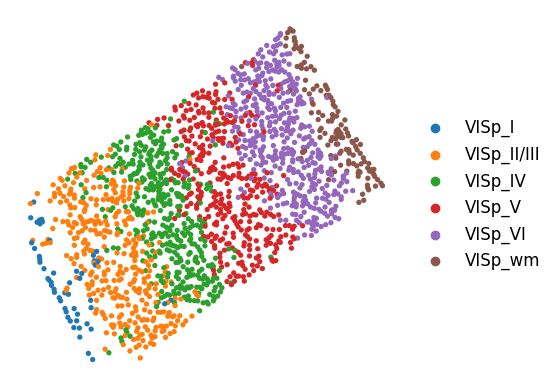

In [145]:
spot_size = 20
pathology_color = ["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD", "#8C564B", "#E377C2", "#7F7F7F"]
sc.pl.spatial(adata_2, img_key=None, color=['transferred_labels'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

In [146]:
adata_1=sc.read_h5ad(r"D:\ppppaper\data\Result\STARMAP_9_banksy_data.h5ad")
adata_1.var_names_make_unique(join="++")
adata_1

AnnData object with n_obs × n_vars = 1053 × 166
    obs: 'ct', 'region', 'Region', 'ground_truth', 'banksy', 'UMAP_1', 'UMAP_2'
    uns: 'ct_colors', 'region_colors'
    obsm: 'X_pca', 'spatial'

In [147]:
adata_2=sc.read_h5ad(r"D:\ppppaper\data\Result\STARMAP_5_banksy_data.h5ad")
adata_2.var_names_make_unique(join="++")
adata_2

AnnData object with n_obs × n_vars = 1049 × 166
    obs: 'ct', 'region', 'Region', 'ground_truth', 'banksy', 'UMAP_1', 'UMAP_2'
    uns: 'ct_colors', 'region_colors'
    obsm: 'X_pca', 'spatial'

In [148]:
embd0 = adata_1.obsm['X_pca']
embd1 = adata_2.obsm['X_pca']
adata_com = sc.concat([adata_1, adata_2], label='slice_name', keys=['slice_1', 'slice_2'])

In [149]:
lisi_scores = compute_lisi_for_adata(adata_com, obsm_key='X_pca', obs_key_list=['ground_truth', 'slice_name'])
print("LISI Scores:\n", lisi_scores)

LISI Scores:
 {'cLISI': 1.1827491572060571, 'iLISI': 1.3296456036962083}


In [ ]:
true_labels_1 = adata_1.obs['ground_truth'].to_numpy()
true_labels_2 = adata_2.obs['ground_truth'].to_numpy()

best, index, distance = spatial_match([embd0, embd1], adatas=[adata_1, adata_2], reorder=False)
valid_indices = best < true_labels_1.size
valid_best = best[valid_indices]
valid_indices = np.arange(len(best))[valid_indices] 

aligned_true_labels_1 = true_labels_1[valid_best]
matched_labels_3 = true_labels_2[valid_indices]

ari = adjusted_rand_score(aligned_true_labels_1, matched_labels_3)
nmi = normalized_mutual_info_score(aligned_true_labels_1, matched_labels_3)

print(f'ARI: {ari}, NMI: {nmi}')

ARI: 0.7491365131722103, NMI: 0.7015264949070747


In [151]:
adata1_df = pd.DataFrame({'index': range(embd0.shape[0]),
                        'x': adata_1.obsm['spatial'][:,0],
                        'y': adata_1.obsm['spatial'][:,1],
                        'celltype': adata_1.obs['ground_truth']})
adata2_df = pd.DataFrame({'index': range(embd1.shape[0]),
                        'x': adata_2.obsm['spatial'][:,0],
                        'y': adata_2.obsm['spatial'][:,1],
                        'celltype': adata_2.obs['ground_truth']})

matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]

In [152]:
adata2_df['target_celltype'] = adata1_df.iloc[matching[1,:],:]['celltype'].to_list()
matching_table = adata2_df.groupby(['celltype','target_celltype']).size().unstack(fill_value=0)

In [153]:
correct_matches = 0
total_matches = 0

for i, row in matching_table.iterrows():
    if i in matching_table.columns and row[i] > 0:
        correct_matches += row[i]
    total_matches += row.sum()


accuracy = correct_matches / total_matches if total_matches > 0 else 0
correct_matches,total_matches,accuracy

(943, 1049, 0.8989513822688274)

In [154]:
first_indices = matching[0]
second_indices = matching[1]
second_array_labels = adata1_df.iloc[second_indices]['celltype'].values
max_index = first_indices.max()
new_labels = np.empty(max_index + 1, dtype=object)

# transfer
new_labels[first_indices] = second_array_labels
adata_2.obs['transferred_labels'] = new_labels

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

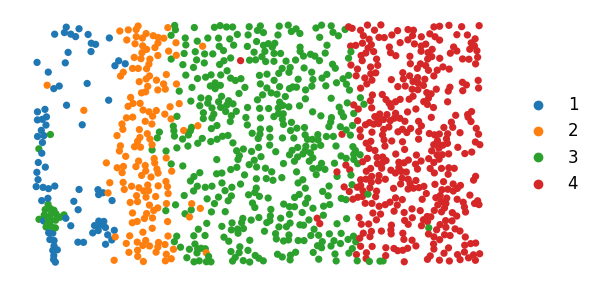

In [155]:
spot_size = 200
adata_2.obs['transferred_labels'] = adata_2.obs['transferred_labels'].astype(str)
sc.pl.spatial(adata_2, img_key=None, color=['transferred_labels'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

In [156]:
adata_1=sc.read_h5ad(r"D:\ppppaper\data\Result\MERFISH_14_banksy_data.h5ad")
adata_1.var_names_make_unique(join="++")
adata_1

AnnData object with n_obs × n_vars = 5926 × 155
    obs: 'cell_class', 'neuron_class', 'domain', 'Region', 'ground_truth', 'banksy', 'UMAP_1', 'UMAP_2'
    uns: 'domain_colors'
    obsm: 'X_pca', 'spatial'

In [157]:
adata_2=sc.read_h5ad(r"D:\ppppaper\data\Result\MERFISH_19_banksy_data.h5ad")
adata_2.var_names_make_unique(join="++")
adata_2

AnnData object with n_obs × n_vars = 5803 × 155
    obs: 'cell_class', 'neuron_class', 'domain', 'Region', 'ground_truth', 'banksy', 'UMAP_1', 'UMAP_2'
    uns: 'domain_colors'
    obsm: 'X_pca', 'spatial'

In [158]:
embd0 = adata_1.obsm['X_pca']
embd1 = adata_2.obsm['X_pca']
adata_com = sc.concat([adata_1, adata_2], label='slice_name', keys=['slice_1', 'slice_2'])

In [159]:
lisi_scores = compute_lisi_for_adata(adata_com, obsm_key='X_pca', obs_key_list=['ground_truth', 'slice_name'])
print("LISI Scores:\n", lisi_scores)

LISI Scores:
 {'cLISI': 1.4124261976187262, 'iLISI': 1.5915294280398777}


In [ ]:
true_labels_1 = adata_1.obs['ground_truth'].to_numpy()
true_labels_2 = adata_2.obs['ground_truth'].to_numpy()

best, index, distance = spatial_match([embd0, embd1], adatas=[adata_1, adata_2], reorder=False)
valid_indices = best < true_labels_1.size
valid_best = best[valid_indices]
valid_indices = np.arange(len(best))[valid_indices] 

aligned_true_labels_1 = true_labels_1[valid_best]
matched_labels_3 = true_labels_2[valid_indices]

ari = adjusted_rand_score(aligned_true_labels_1, matched_labels_3)
nmi = normalized_mutual_info_score(aligned_true_labels_1, matched_labels_3)

print(f'ARI: {ari}, NMI: {nmi}')

ARI: 0.5905159141958244, NMI: 0.649787706042589


In [161]:
adata1_df = pd.DataFrame({'index': range(embd0.shape[0]),
                        'x': adata_1.obsm['spatial'][:,0],
                        'y': adata_1.obsm['spatial'][:,1],
                        'celltype': adata_1.obs['ground_truth']})
adata2_df = pd.DataFrame({'index': range(embd1.shape[0]),
                        'x': adata_2.obsm['spatial'][:,0],
                        'y': adata_2.obsm['spatial'][:,1],
                        'celltype': adata_2.obs['ground_truth']})

matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]

In [162]:
adata2_df['target_celltype'] = adata1_df.iloc[matching[1,:],:]['celltype'].to_list()
matching_table = adata2_df.groupby(['celltype','target_celltype']).size().unstack(fill_value=0)

In [163]:
correct_matches = 0
total_matches = 0

for i, row in matching_table.iterrows():
    if i in matching_table.columns and row[i] > 0:
        correct_matches += row[i]
    total_matches += row.sum()


accuracy = correct_matches / total_matches if total_matches > 0 else 0
correct_matches,total_matches,accuracy

(4617, 5803, 0.7956229536446665)

In [164]:
first_indices = matching[0]
second_indices = matching[1]
second_array_labels = adata1_df.iloc[second_indices]['celltype'].values
max_index = first_indices.max()
new_labels = np.empty(max_index + 1, dtype=object)

# transfer
new_labels[first_indices] = second_array_labels
adata_2.obs['transferred_labels'] = new_labels

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

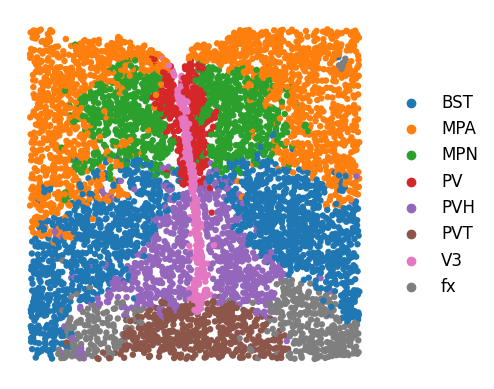

In [165]:
spot_size = 35
sc.pl.spatial(adata_2, img_key=None, color=['transferred_labels'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

In [166]:
adata_1=sc.read_h5ad(r"D:\ppppaper\data\Result\DFPLC_74_banksy_data.h5ad")
adata_1.var_names_make_unique(join="++")
adata_1

AnnData object with n_obs × n_vars = 3673 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'annotation', 'banksy', 'UMAP_1', 'UMAP_2'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'X_pca', 'spatial'

In [167]:
adata_2=sc.read_h5ad(r"D:\ppppaper\data\Result\DFPLC_75_banksy_data.h5ad")
adata_2.var_names_make_unique(join="++")
adata_2

AnnData object with n_obs × n_vars = 3592 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'annotation', 'UMAP_1', 'UMAP_2', 'banksy'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'X_pca', 'spatial'

In [168]:
embd0 = adata_1.obsm['X_pca']
embd1 = adata_2.obsm['X_pca']
adata_com = sc.concat([adata_1, adata_2], label='slice_name', keys=['slice_1', 'slice_2'])

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [169]:
lisi_scores = compute_lisi_for_adata(adata_com, obsm_key='X_pca', obs_key_list=['annotation', 'slice_name'])
print("LISI Scores:\n", lisi_scores)

LISI Scores:
 {'cLISI': 1.4093751584078684, 'iLISI': 1.6877740273650865}


In [ ]:
true_labels_1 = adata_1.obs['annotation'].to_numpy()
true_labels_2 = adata_2.obs['annotation'].to_numpy()

best, index, distance = spatial_match([embd0, embd1], adatas=[adata_1, adata_2], reorder=False)
valid_indices = best < true_labels_1.size
valid_best = best[valid_indices]
valid_indices = np.arange(len(best))[valid_indices] 

aligned_true_labels_1 = true_labels_1[valid_best]
matched_labels_3 = true_labels_2[valid_indices]

ari = adjusted_rand_score(aligned_true_labels_1, matched_labels_3)
nmi = normalized_mutual_info_score(aligned_true_labels_1, matched_labels_3)

print(f'ARI: {ari}, NMI: {nmi}')

ARI: 0.6458183691659093, NMI: 0.6775877003636738


In [171]:
adata1_df = pd.DataFrame({'index': range(embd0.shape[0]),
                        'x': adata_1.obsm['spatial'][:,0],
                        'y': adata_1.obsm['spatial'][:,1],
                        'celltype': adata_1.obs['annotation']})
adata2_df = pd.DataFrame({'index': range(embd1.shape[0]),
                        'x': adata_2.obsm['spatial'][:,0],
                        'y': adata_2.obsm['spatial'][:,1],
                        'celltype': adata_2.obs['annotation']})

matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]

In [172]:
adata2_df['target_celltype'] = adata1_df.iloc[matching[1,:],:]['celltype'].to_list()
matching_table = adata2_df.groupby(['celltype','target_celltype']).size().unstack(fill_value=0)

In [173]:
correct_matches = 0
total_matches = 0

for i, row in matching_table.iterrows():
    if i in matching_table.columns and row[i] > 0:
        correct_matches += row[i]
    total_matches += row.sum()


accuracy = correct_matches / total_matches if total_matches > 0 else 0
correct_matches,total_matches,accuracy

(2879, 3592, 0.8015033407572383)

In [174]:
first_indices = matching[0]
second_indices = matching[1]
second_array_labels = adata1_df.iloc[second_indices]['celltype'].values
max_index = first_indices.max()
new_labels = np.empty(max_index + 1, dtype=object)

# transfer
new_labels[first_indices] = second_array_labels
adata_2.obs['transferred_labels'] = new_labels

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

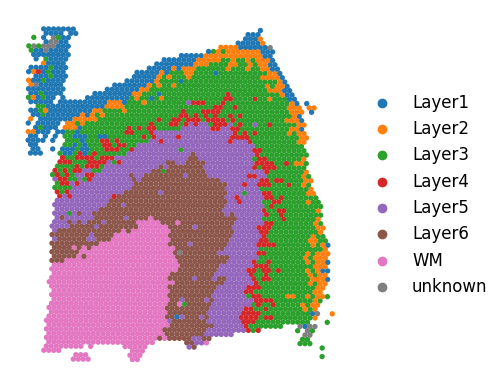

In [176]:
spot_size = 150
sc.pl.spatial(adata_2, img_key=None, color=['transferred_labels'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)